Device: cpu
../../Detector completos/Dataset-Comida-Chilena-1/train/images\descarga_jpg.rf.53c4ac7283dc2d65b76a1a7ed17712ec.jpg
✅ Predicción: 93.05 / 100  |  Real: 100.00  |  Δ=6.95


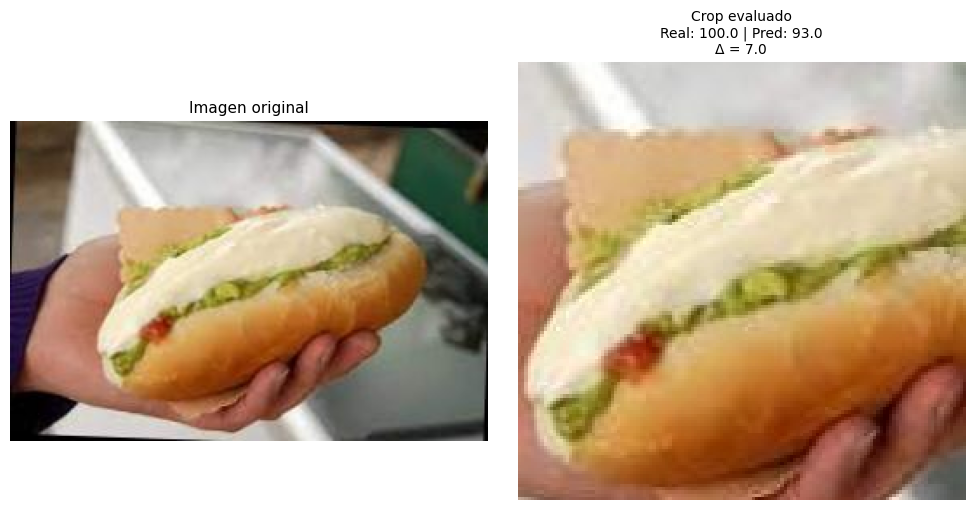

In [ ]:
# =========================================================
# 🔹 INFERENCIA INDIVIDUAL CON VISUALIZACIÓN COMPLETA
# =========================================================
from PIL import Image

import matplotlib.pyplot as plt
import pandas as pd
import os, ast, math, random
from pathlib import Path
import numpy as np
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights


CROP_DIR = "dataset/crops"
MERGED_CSV_PATH = "dataset_regresion_extendido.csv"
IMG_SIZE = 224

weights = MobileNet_V3_Small_Weights.IMAGENET1K_V1
_mean, _std = weights.transforms().mean, weights.transforms().std
inference_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=_mean, std=_std),
])

# Cargar dataset para poder buscar la nota real
merged = pd.read_csv(MERGED_CSV_PATH)
if "score_clean" not in merged.columns:
    import ast
    def clean_score_cell(x):
        try:
            if isinstance(x, str):
                data = ast.literal_eval(x)
                if isinstance(data, list) and data and isinstance(data[0], dict) and "number" in data[0]:
                    return float(data[0]["number"])
                return float(x)
            return float(x)
        except Exception:
            return None
    merged["score_clean"] = merged["score"].apply(clean_score_cell)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

model = mobilenet_v3_small(weights=weights)
in_f = model.classifier[3].in_features
model.classifier[3] = nn.Sequential(nn.Linear(in_f, 1), nn.Sigmoid())
model = model.to(device)
model.load_state_dict(torch.load("checkpoints/best_model.pth", map_location=device))
model.eval()

def predecir_y_mostrar_con_real(ruta_imagen_original, split="test"):
    """
    Muestra imagen original + crop, e imprime nota real vs predicha.
    """
    base = os.path.basename(ruta_imagen_original)
    crop_name = f"crop_{split}_{base}"
    crop_path = os.path.join(CROP_DIR, crop_name)

    if not os.path.exists(crop_path):
        raise FileNotFoundError(f"No se encontró el crop: {crop_path}")

    img_original = Image.open(ruta_imagen_original).convert("RGB")
    img_crop = Image.open(crop_path).convert("RGB")
    real = None

    ruta_norm = ruta_imagen_original.replace("\\", "/")
    merged["img_path_norm"] = merged["img_path"].astype(str).apply(lambda x: x.replace("\\", "/"))
    match = merged[merged["img_path_norm"].str.endswith(os.path.basename(ruta_norm), na=False)]

    if len(match) > 0:
        real = float(match.iloc[0]["score_clean"])

    # inferencia
    img_t = inference_tfms(img_crop).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        pred = model(img_t).cpu().numpy().flatten()[0] * 100.0
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(img_original)
    axes[0].axis("off")
    axes[0].set_title("Imagen original", fontsize=11)

    axes[1].imshow(img_crop)
    axes[1].axis("off")

    if real is not None:
        delta = abs(pred - real)
        axes[1].set_title(f"Crop evaluado\nReal: {real:.1f} | Pred: {pred:.1f}\nΔ = {delta:.1f}", fontsize=10)
        print(f"✅ Predicción: {pred:.2f} / 100  |  Real: {real:.2f}  |  Δ={delta:.2f}")
    else:
        axes[1].set_title(f"Crop evaluado\nPredicción: {pred:.1f} / 100", fontsize=10)
        print(f"✅ Predicción: {pred:.2f} / 100 (sin nota real en CSV)")

    plt.tight_layout()
    plt.show()

    return pred, real, crop_path


"""
#34_jpg.rf.3274f9678b84ec683a1edf1d20ad527e.jpg
pred, real, crop_path = predecir_y_mostrar_con_real(
    r"../../Detector completos/Dataset-Comida-Chilena-1\train\images\112_jpg.rf.1f0aa54d9b7400df7d6795bc2b24651d.jpg",
    split="train"
)
"""

import random, glob

# Carpeta donde buscar las imágenes
carpeta = r"../../Detector completos/Dataset-Comida-Chilena-1/train/images"

# Buscar todas las .jpg y elegir una al azar
imagenes = glob.glob(os.path.join(carpeta, "*.jpg"))
ruta_aleatoria = random.choice(imagenes)
print(ruta_aleatoria)
# Usar esa ruta en tu llamada normal
pred, real, crop_path = predecir_y_mostrar_con_real(ruta_aleatoria, split="train")
